Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 155       
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: -7 global_step 95   epsilon: 0.9905445119027773


TclError: invalid command name ".!canvas"

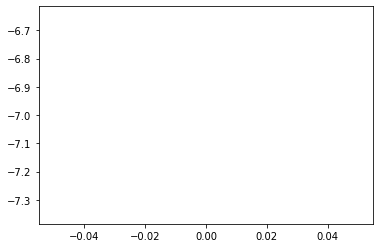

In [2]:
import copy
import pylab
import random
import numpy as np
from environment import Env
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 1000

# 그리드월드 예제에서의 딥살사 에이전트
class DeepSARSAgent:
    def __init__(self):
        self.load_model = False
        # 에이전트가 가능한 모든 행동 정의
        self.action_space = [0, 1, 2, 3, 4]
        # 상태의 크기와 행동의 크기 정의
        self.action_size = len(self.action_space)
        self.state_size = 15
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.epsilon = 1.  # exploration
        self.epsilon_decay = .9999
        self.epsilon_min = 0.01
        self.model = self.build_model()

        if self.load_model:
            self.epsilon = 0.05
            self.model.load_weights('./save_model/deep_sarsa_trained.h5')

    # 상태가 입력 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 입실론 탐욕 방법으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            # 무작위 행동 반환
            return random.randrange(self.action_size)
        else:
            # 모델로부터 행동 산출
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]
        # 살사의 큐함수 업데이트 식
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor *
                              self.model.predict(next_state)[0][next_action])

        # 출력 값 reshape
        target = np.reshape(target, [1, 5])
        # 인공신경망 업데이트
        self.model.fit(state, target, epochs=1, verbose=0)


if __name__ == "__main__":
    # 환경과 에이전트 생성
    env = Env()
    agent = DeepSARSAgent()

    global_step = 0
    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, 15])

        while not done:
            # env 초기화
            global_step += 1

            # 현재 상태에 대한 행동 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행 후 샘플 수집
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, 15])
            next_action = agent.get_action(next_state)
            # 샘플로 모델 학습
            agent.train_model(state, action, reward, next_state, next_action,
                              done)
            state = next_state
            score += reward

            state = copy.deepcopy(next_state)

            if done:
                # 에피소드마다 학습 결과 출력
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("./save_graph/deep_sarsa_.png")
                print("episode:", e, "  score:", score, "global_step",
                      global_step, "  epsilon:", agent.epsilon)

        # 100 에피소드마다 모델 저장
        if e % 100 == 0:
            agent.model.save_weights("./save_model/deep_sarsa.h5")
